In [2]:
#Importing libraries
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import random


In [3]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Loading train data
data = scipy.io.loadmat('/content/drive/MyDrive/Xtrain.mat')
x = data['Xtrain'].flatten()  # [1000,] shape
print("Data shape:", x.shape)


Data shape: (1000,)


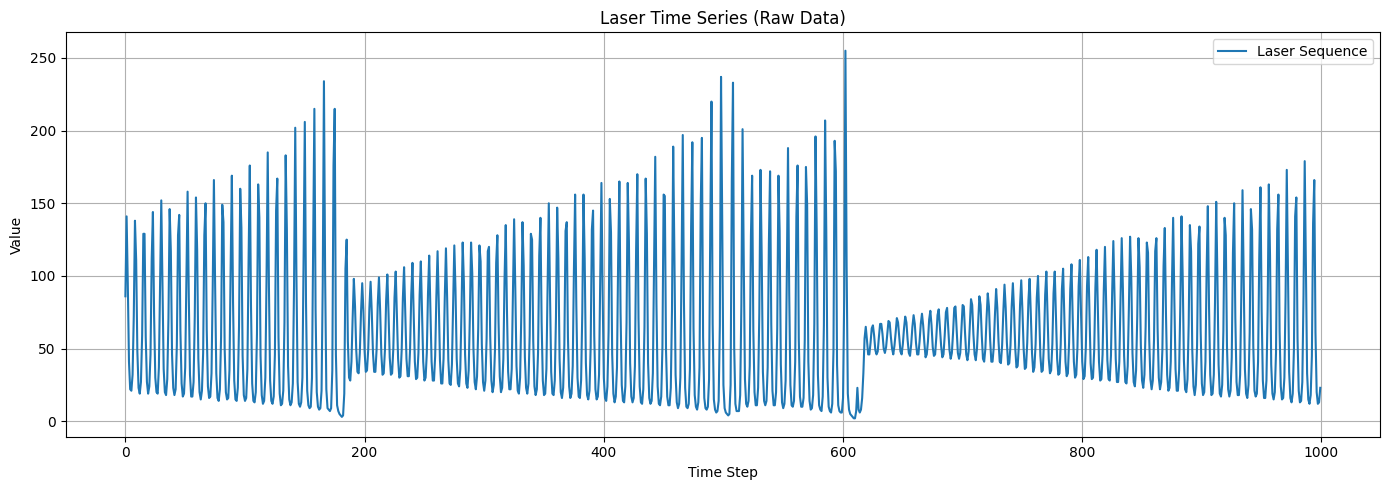

In [5]:
#Visualizating training data

plt.figure(figsize=(14, 5))
plt.plot(x, label='Laser Sequence')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Laser Time Series (Raw Data)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Gaussian (Z-score) normalization
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.reshape(-1, 1)).flatten()


Split the dataset into k+1

In [7]:
#Creating sequences of dataset
def create_sequences(data, k, shuffle=True):
    sequences = []
    for i in range(len(data) - k):
        x_seq = data[i:i + k]
        y = data[i + k]  # 1-step-ahead target
        sequences.append((x_seq, y))

    if shuffle:
        random.shuffle(sequences)

    X, y = zip(*sequences)
    X = np.array(X)[..., np.newaxis]  # shape: (batch, k, 1)
    y = np.array(y)  # shape: (batch,)
    return X, y



In [8]:
# Hyperparameter options
tcn_layers_options = [3, 4, 5, 6]
tcn_kernel_sizes   = [2, 3, 5, 7]
tcn_lr_grid        = [0.003, 0.0005, 0.0001]
tcn_dropout_grid   = [0.0, 0.1, 0.2, 0.3]
tcn_activation     = ['relu', 'tanh', 'gelu']
tcn_norm_types     = ['group', 'layer']
k_values           = range(10, 100, 5)
forecast_horizon   = 200  # Fixed prediction length

# Create full hyperparameter grid
tcn_grid = list(itertools.product(
    k_values,
    tcn_layers_options,
    tcn_kernel_sizes,
    tcn_lr_grid,
    tcn_dropout_grid,
    tcn_activation,
    tcn_norm_types
))

# Sample a subset to evaluate (e.g. 40)
random.seed(42)
sampled_tcn_grid = random.sample(tcn_grid, k=40)



In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, ReLU, Layer, Input, Lambda, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import LayerNormalization

# Custom Group Normalization Layer
class GroupNorm(Layer):
    def __init__(self, groups, channels, epsilon=1e-5):
        super(GroupNorm, self).__init__()
        self.groups = groups
        self.channels = channels
        self.epsilon = epsilon
        self.gamma = self.add_weight(shape=(channels,), initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(channels,), initializer='zeros', trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        x = tf.reshape(inputs, [batch_size, -1, self.groups, self.channels // self.groups])
        mean, var = tf.nn.moments(x, axes=[2, 3], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        x = tf.reshape(x, [batch_size, -1, self.channels])
        return x * self.gamma + self.beta

# # TCN residual block
class ResidualSliceMatch(tf.keras.layers.Layer):
    def call(self, inputs):
        res, x = inputs
        target_time = tf.shape(x)[1]
        return res[:, -target_time:, :]




# TCN Block
def tcn_block(inputs, out_channels, kernel_size, dilation, name=None,
              activation='relu', norm_type='group', dropout=0.1):

    x = Conv1D(out_channels, kernel_size, padding='same', dilation_rate=dilation, name=name)(inputs)

    # Normalization
    if norm_type == 'group':
        x = GroupNorm(1, out_channels)(x)
    elif norm_type == 'layer':
        x = LayerNormalization()(x)
    else:
        raise ValueError(f"Unsupported norm_type: {norm_type}")

    # Activation
    if activation == 'relu':
        x = ReLU()(x)
    elif activation == 'tanh':
        x = tf.keras.layers.Activation('tanh')(x)
    elif activation == 'gelu':
        x = tf.keras.layers.Activation(tf.nn.gelu)(x)
    else:
        raise ValueError(f"Unsupported activation: {activation}")

    x = Dropout(dropout)(x)
    return x


# TCN architecture
def build_tcn(k, kernel_size=5, n_layers=6, drop=0.1, lr=0.001, target_length=200,
              activation='relu', norm_type='group'):

    inputs = Input(shape=(k, 1))
    x = inputs
    dilation = 1
    channel_list = [16, 32, 64, 64, 128, 128][:n_layers]

    for i, channels in enumerate(channel_list):
        res = x
        x = tcn_block(x, channels, kernel_size, dilation,
                      name=f'tcn_block_{i}',
                      activation=activation,
                      norm_type=norm_type,
                      dropout=drop)

        if res.shape[-1] != x.shape[-1]:
            if i > 0:
                res = Conv1D(channels, kernel_size=1)(res)
            else:
                res = ResidualSliceMatch()([res, x])

        x = Add()([x, res])
        dilation *= 2

    x = Conv1D(1, kernel_size=1)(x)
    x = Lambda(lambda t: t[:, -1, :], output_shape=(1,))(x)  # take last timestep
    outputs = Lambda(lambda t: tf.squeeze(t, axis=1), output_shape=())(x)  # squeeze to (batch,)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=[MeanAbsoluteError()])
    return model


In [10]:

# calculating best combinations of parameters
best_combo = None
best_score = float('inf')
forecast_horizon = 1
n_splits = 5

for (k, n_layers, kernel_size, lr, dropout, activation, norm_type) in sampled_tcn_grid:
    # Prepare data
    X_all, y_all = create_sequences(x_scaled, k, shuffle=True)

    # Reshape input for TCN: [batch, time, channels]
    X_all = X_all[..., np.newaxis]  # shape: (batch_size, k, 1)

    kf = KFold(n_splits=n_splits, shuffle=True)
    fold_mse_scores = []

    for train_idx, val_idx in kf.split(X_all):

    # Manual 80/20 split
      split_idx = int(len(X_all) * 0.8)
      X_tr, X_val = X_all[:split_idx], X_all[split_idx:]
      y_tr, y_val = y_all[:split_idx], y_all[split_idx:]

      # Build and train TCN
      model = build_tcn(
          k=k,
          kernel_size=kernel_size,
          n_layers=n_layers,
          drop=dropout,
          lr=lr,
          target_length=forecast_horizon,
          activation=activation,
          norm_type=norm_type
      )

      model.fit(X_tr, y_tr, epochs=20, verbose=0)
      loss, mse = model.evaluate(X_val, y_val, verbose=0)
      fold_mse_scores.append(mse)

    avg_mse = np.mean(fold_mse_scores)
    print(f"{k=}, {n_layers=}, {kernel_size=}, {lr=:.0e}, {dropout=:.1f}, "
          f"{activation=}, {norm_type=}, avg_mse={avg_mse:.4f}")

    if avg_mse < best_score:
        best_score = avg_mse
        best_combo = (k, n_layers, kernel_size, lr, dropout, activation, norm_type)

print("\nBest TCN:", best_combo, "->", best_score)


k=25, n_layers=3, kernel_size=5, lr=1e-04, dropout=0.0, activation='relu', norm_type='group', avg_mse=0.1236
k=10, n_layers=5, kernel_size=7, lr=5e-04, dropout=0.0, activation='tanh', norm_type='layer', avg_mse=0.0847
k=45, n_layers=6, kernel_size=3, lr=3e-03, dropout=0.2, activation='relu', norm_type='group', avg_mse=0.1602
k=40, n_layers=6, kernel_size=7, lr=5e-04, dropout=0.1, activation='tanh', norm_type='group', avg_mse=0.1681
k=40, n_layers=4, kernel_size=3, lr=5e-04, dropout=0.3, activation='relu', norm_type='group', avg_mse=0.1479
k=25, n_layers=6, kernel_size=7, lr=5e-04, dropout=0.2, activation='relu', norm_type='group', avg_mse=0.1362
k=20, n_layers=6, kernel_size=5, lr=5e-04, dropout=0.3, activation='gelu', norm_type='group', avg_mse=0.1479
k=85, n_layers=5, kernel_size=2, lr=3e-03, dropout=0.2, activation='tanh', norm_type='group', avg_mse=0.1992
k=20, n_layers=4, kernel_size=7, lr=5e-04, dropout=0.2, activation='gelu', norm_type='group', avg_mse=0.1160
k=90, n_layers=6, k

Data shape: (990, 10, 1, 1)
Training fold 1...
Fold 1 - Training Loss: 0.0047, Training MAE: 0.0477
Fold 1 - Validation Loss: 0.0101, Validation MAE: 0.0803


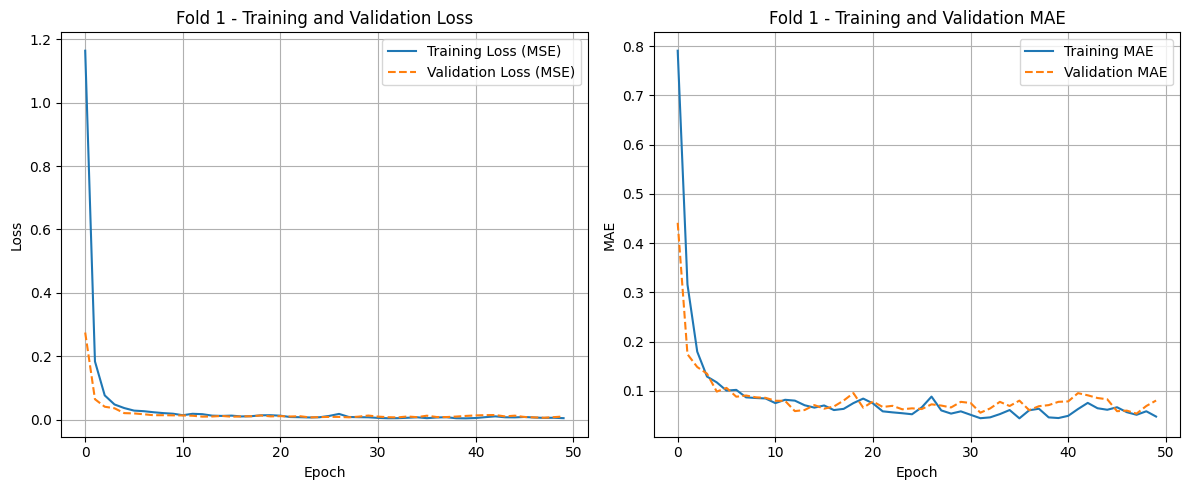

Training fold 2...
Fold 2 - Training Loss: 0.0029, Training MAE: 0.0379
Fold 2 - Validation Loss: 0.0066, Validation MAE: 0.0527


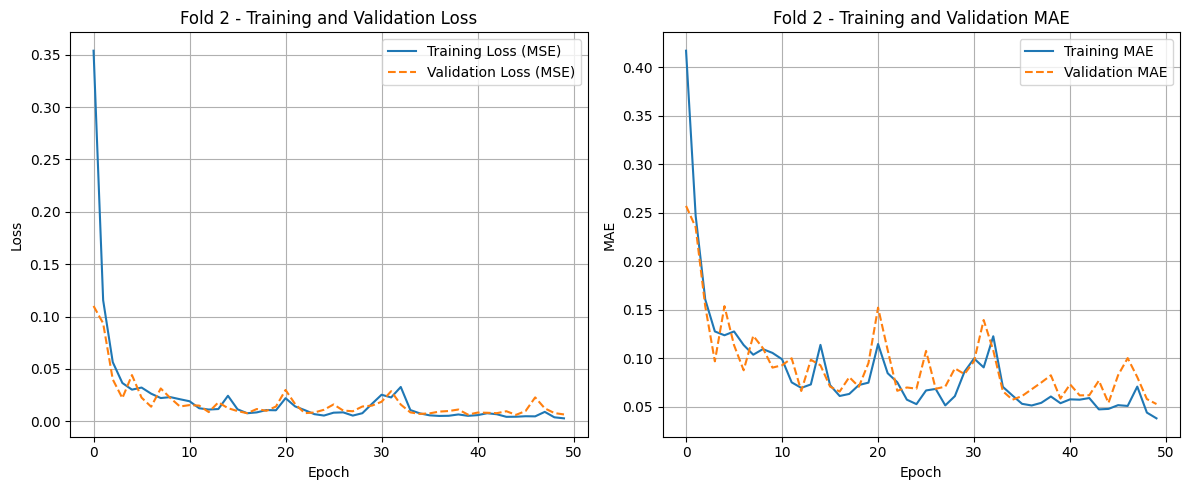

Training fold 3...
Fold 3 - Training Loss: 0.0038, Training MAE: 0.0469
Fold 3 - Validation Loss: 0.0135, Validation MAE: 0.0609


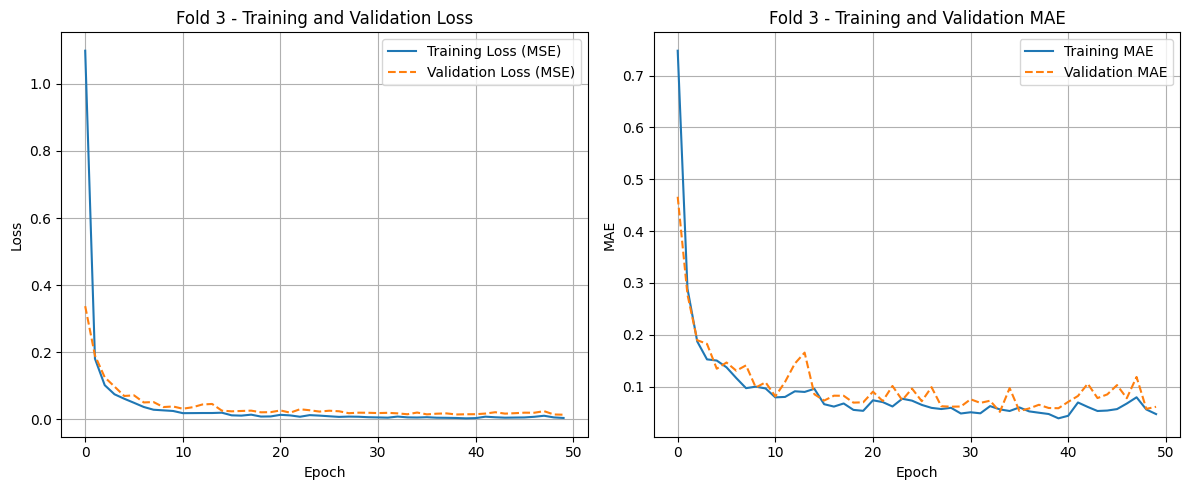

Training fold 4...
Fold 4 - Training Loss: 0.0064, Training MAE: 0.0541
Fold 4 - Validation Loss: 0.0454, Validation MAE: 0.0947


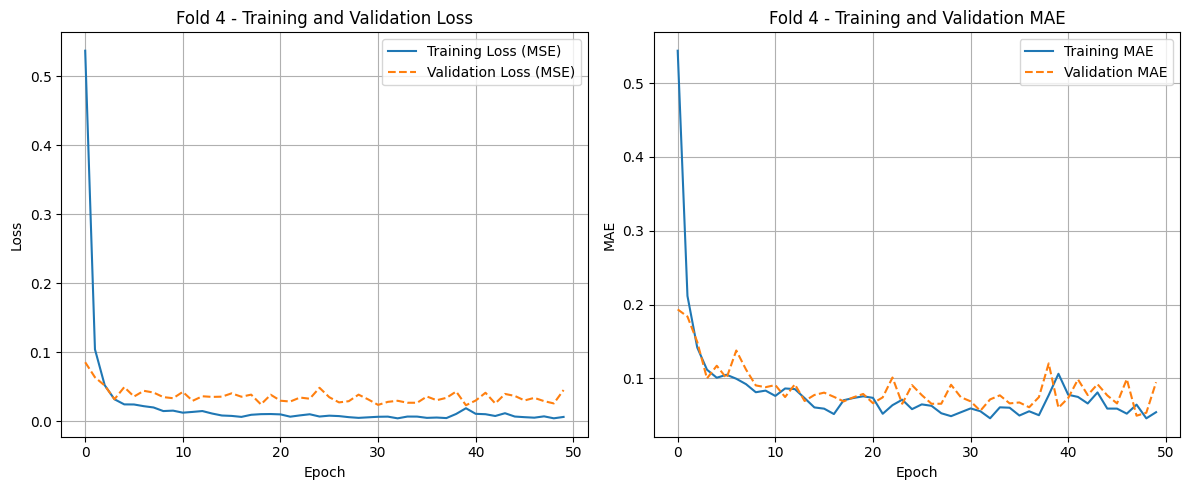

Training fold 5...
Fold 5 - Training Loss: 0.0040, Training MAE: 0.0485
Fold 5 - Validation Loss: 0.0407, Validation MAE: 0.1009


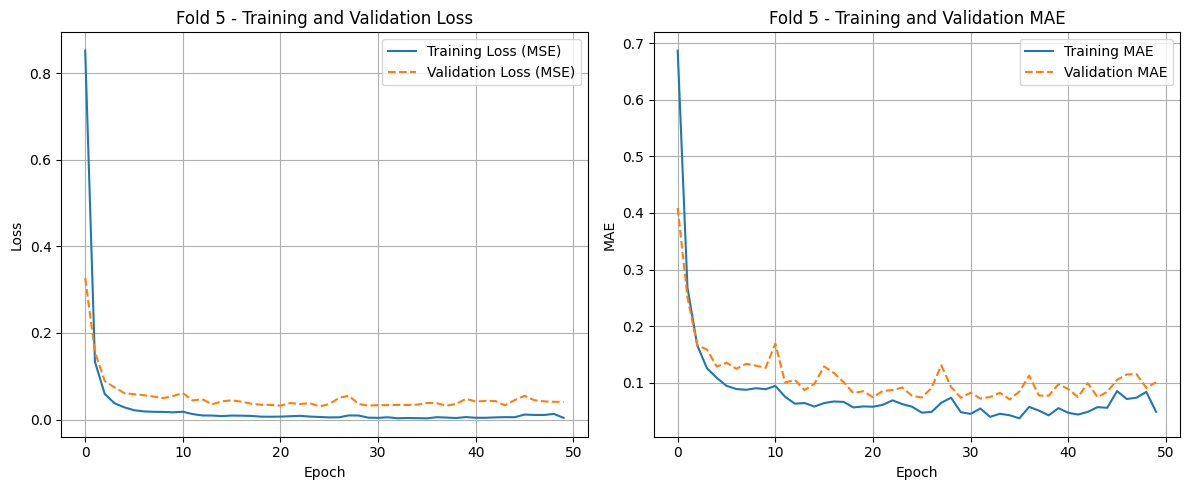


Average Training Loss (MSE): 0.0044
Average Training MAE: 0.0470
Average Validation Loss (MSE): 0.0233
Average Validation MAE: 0.0779


In [13]:
# 5 fold Cross validation
best_k, n_layers, kernel_size, lr, dropout, activation, norm_type = best_combo
X, y = create_sequences(x_scaled, best_k)
X = X[..., np.newaxis]  # Reshape for TCN: (batch, k, 1)
print("Data shape:", X.shape)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics
losses = []
maes = []
val_losses = []
val_maes = []
models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}...")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build the best TCN model for each fold
    final_model = build_tcn(
        k=best_k,
        kernel_size=kernel_size,
        n_layers=n_layers,
        drop=dropout,
        lr=lr,
        target_length=1,  # 1-step prediction
        activation=activation,
        norm_type=norm_type
    )

    final_model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=[MeanAbsoluteError()]
    )

    history = final_model.fit(
        X_train, y_train,
        epochs=50,
        validation_data=(X_val, y_val),
        verbose=0
    )
    models.append(final_model)

    # Store final epoch metrics
    losses.append(history.history['loss'][-1])
    maes.append(history.history['mean_absolute_error'][-1])
    val_losses.append(history.history['val_loss'][-1])
    val_maes.append(history.history['val_mean_absolute_error'][-1])

    print(f"Fold {fold + 1} - Training Loss: {history.history['loss'][-1]:.4f}, Training MAE: {history.history['mean_absolute_error'][-1]:.4f}")
    print(f"Fold {fold + 1} - Validation Loss: {history.history['val_loss'][-1]:.4f}, Validation MAE: {history.history['val_mean_absolute_error'][-1]:.4f}")

    # Plot for this fold
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {fold + 1} - Training and Validation Loss")
    plt.grid(True)
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title(f"Fold {fold + 1} - Training and Validation MAE")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Report averaged results
avg_train_loss = np.mean(losses)
avg_train_mae = np.mean(maes)
avg_val_loss = np.mean(val_losses)
avg_val_mae = np.mean(val_maes)

print(f"\nAverage Training Loss (MSE): {avg_train_loss:.4f}")
print(f"Average Training MAE: {avg_train_mae:.4f}")
print(f"Average Validation Loss (MSE): {avg_val_loss:.4f}")
print(f"Average Validation MAE: {avg_val_mae:.4f}")


In [14]:
def iterative_tcn_forecast(model, train_set, scaler, lookback, n_steps=500):
    #Iteratively predict n_steps into the future using a trained TCN model.

    current_input = train_set[-lookback:].reshape(1, lookback, 1)  # shape (1, k, 1)
    predictions = []

    for _ in range(n_steps):
        next_val = model.predict(current_input, verbose=0)[0]  # scalar prediction
        predictions.append(next_val)
        # Update input: remove oldest, append new prediction
        next_val_reshaped = np.array([[[next_val]]])  # shape (1, 1, 1)
        current_input = np.concatenate([current_input[:, 1:, :], next_val_reshaped], axis=1)

    # Inverse transform predictions to original scale
    pred_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return pred_unscaled




 Predicting next 200 steps with model 1


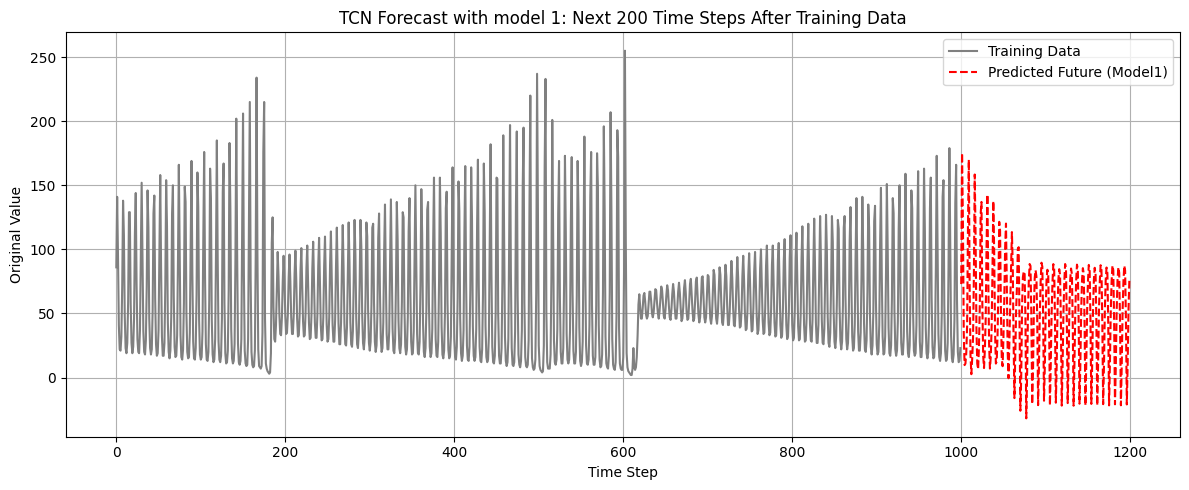


 Predicting next 200 steps with model 2


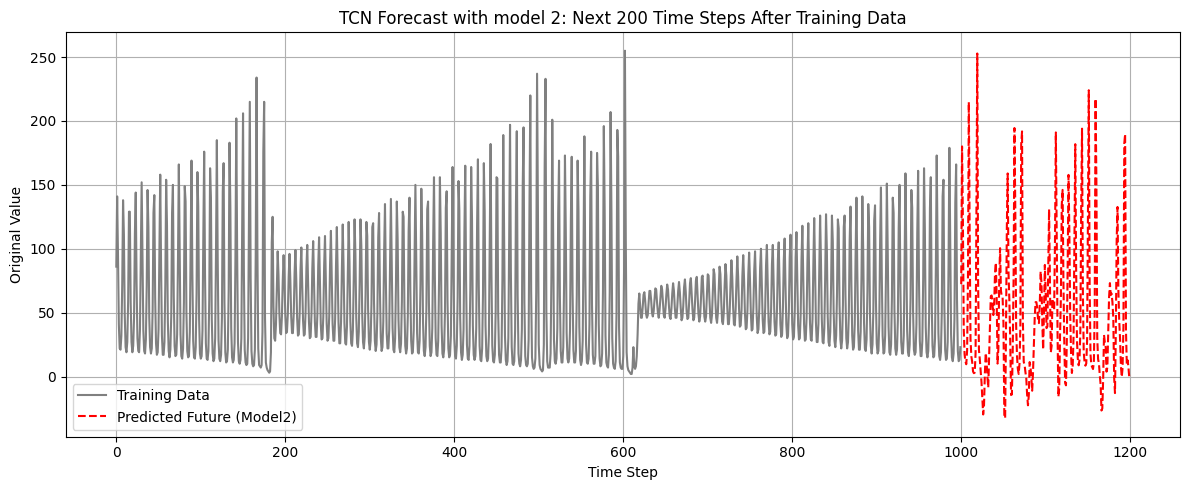


 Predicting next 200 steps with model 3


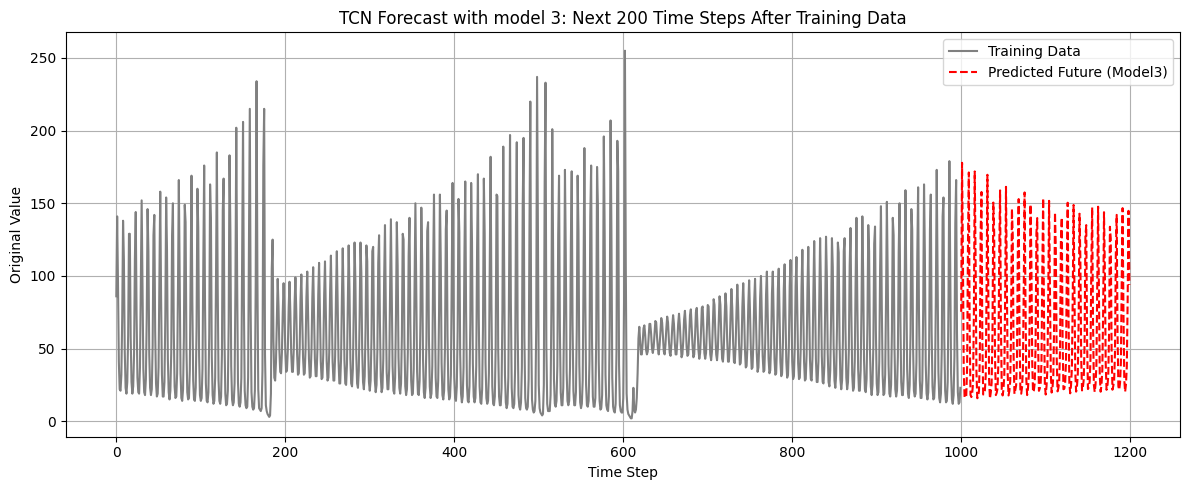


 Predicting next 200 steps with model 4


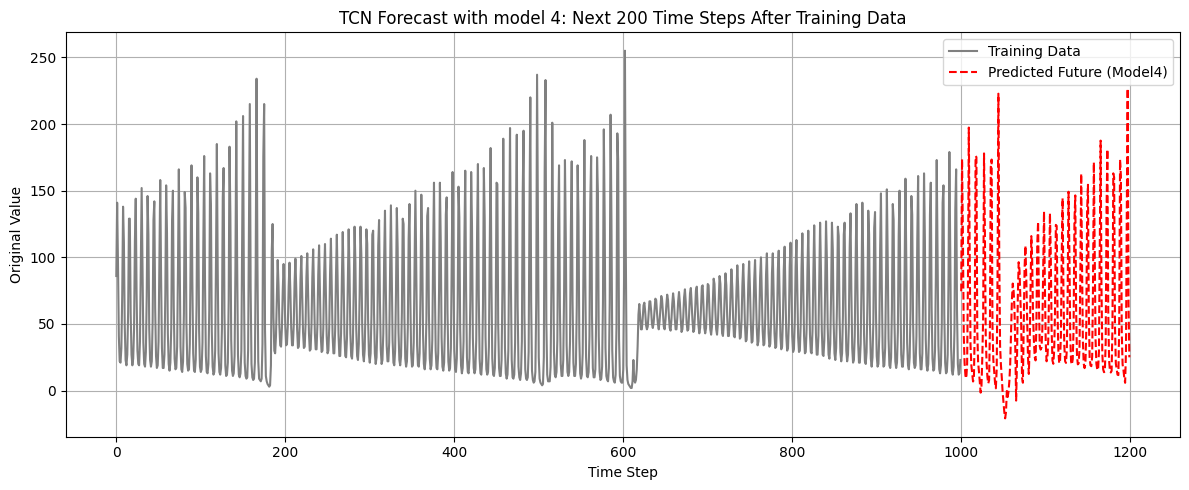


 Predicting next 200 steps with model 5


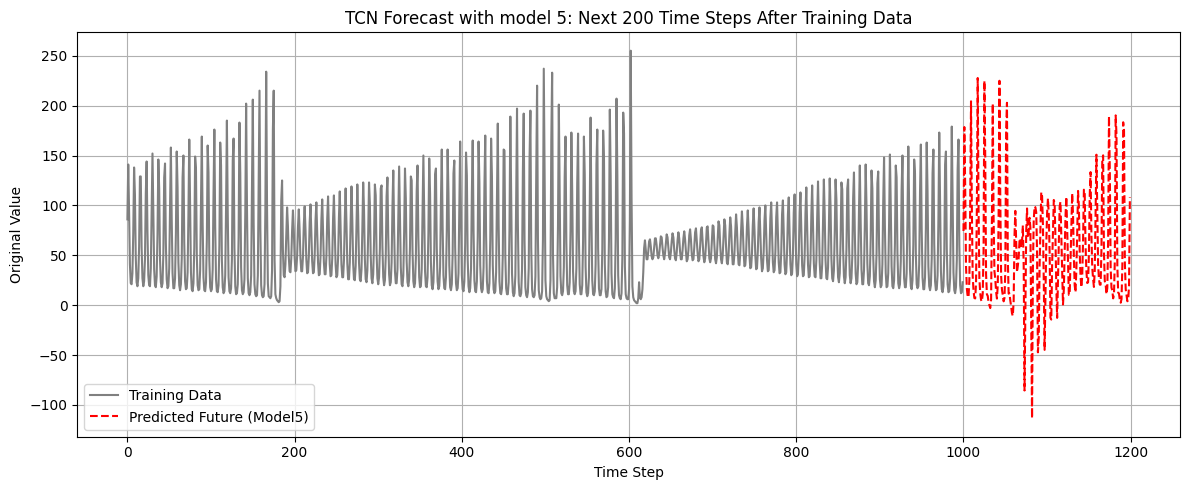

In [15]:
#Forcasting 200 points after training data for each model
train_set = x_scaled
test_set = x_scaled[:200]

X_train, y_train = create_sequences(train_set, best_k)
X_train = X_train[..., np.newaxis]  # Reshape for TCN: (batch, k, 1)

train_original = scaler.inverse_transform(train_set.reshape(-1, 1)).flatten()
train_len = len(train_set)

for i, model in enumerate(models):
    # Forecast using your final trained TCN model
    print(f"\n Predicting next 200 steps with model {i+1}")
    tcn_preds = iterative_tcn_forecast(model, train_set, scaler, best_k, n_steps=200)
    prediction_timeline = np.arange(train_len, train_len + len(tcn_preds))

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(train_original, label='Training Data', color='gray')
    plt.plot(prediction_timeline, tcn_preds, label=f'Predicted Future (Model{i+1})', color='red', linestyle='--')
    plt.title(f"TCN Forecast with model {i+1}: Next 200 Time Steps After Training Data")
    plt.xlabel("Time Step")
    plt.ylabel("Original Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


 Predicting next 500 steps with model 1


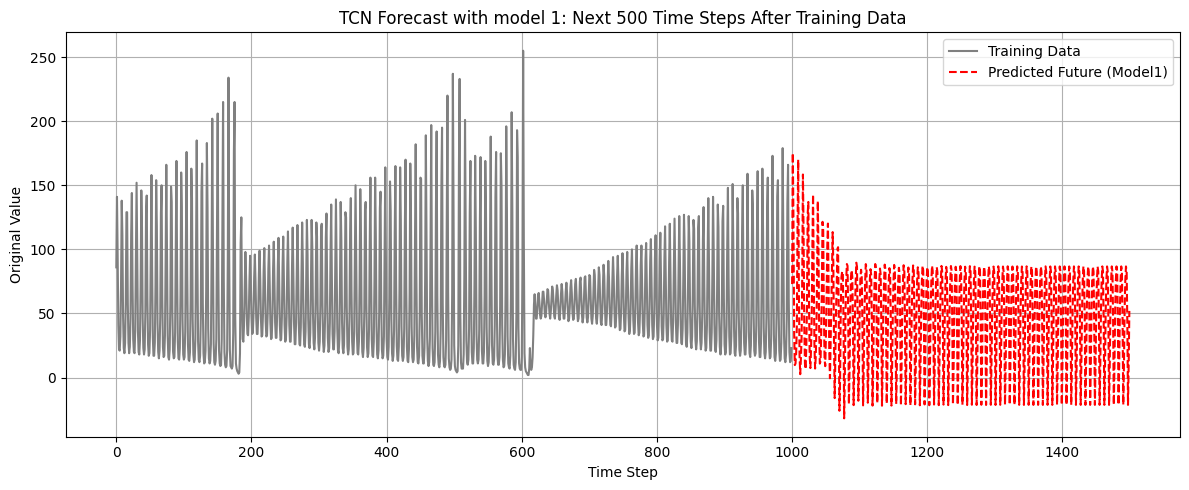


 Predicting next 500 steps with model 2


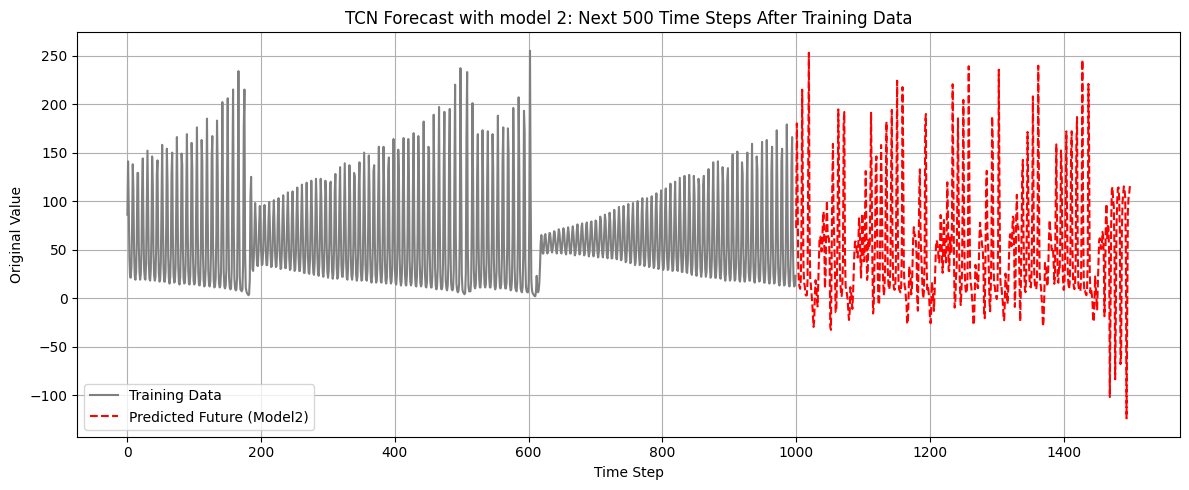


 Predicting next 500 steps with model 3


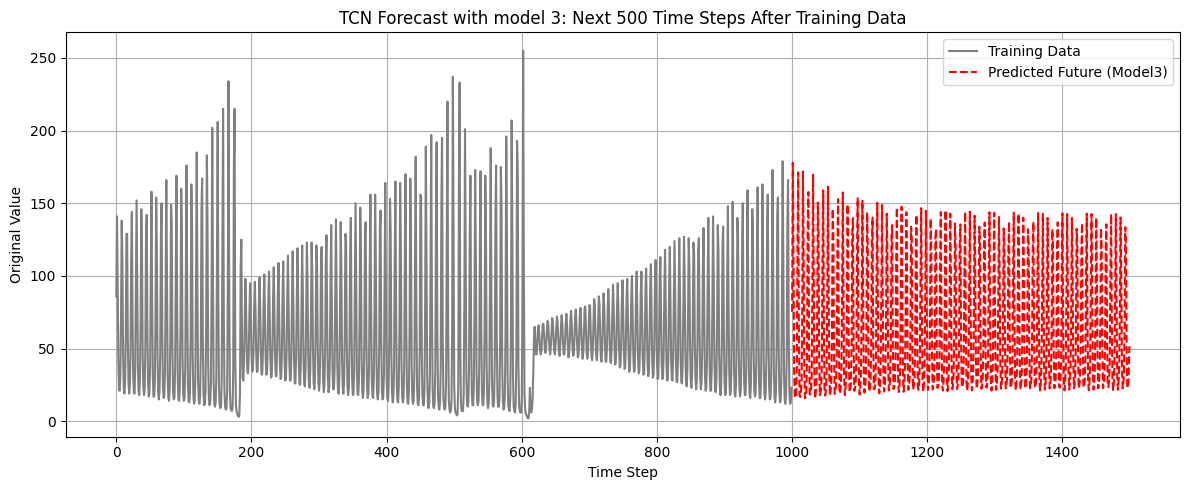


 Predicting next 500 steps with model 4


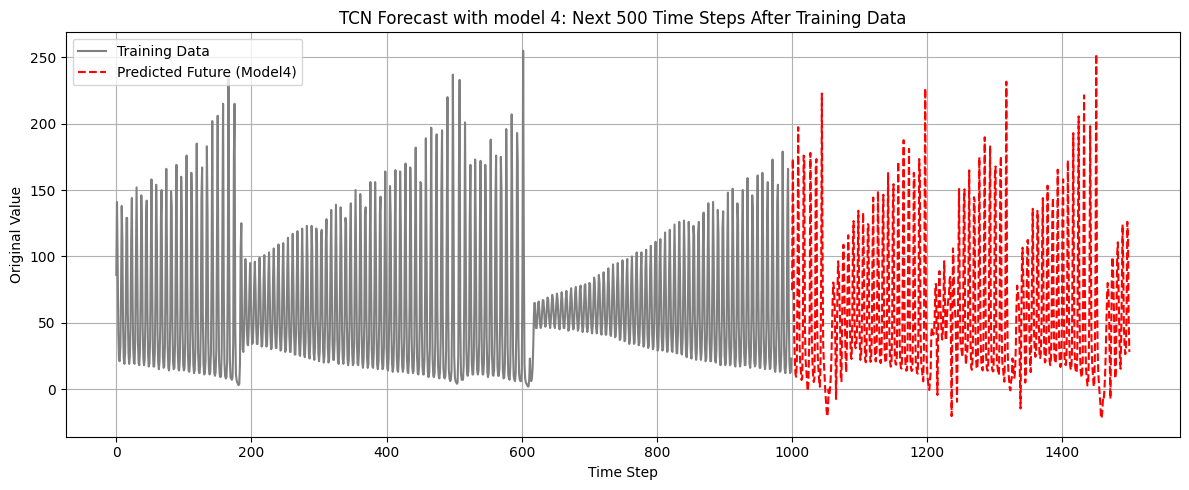


 Predicting next 500 steps with model 5


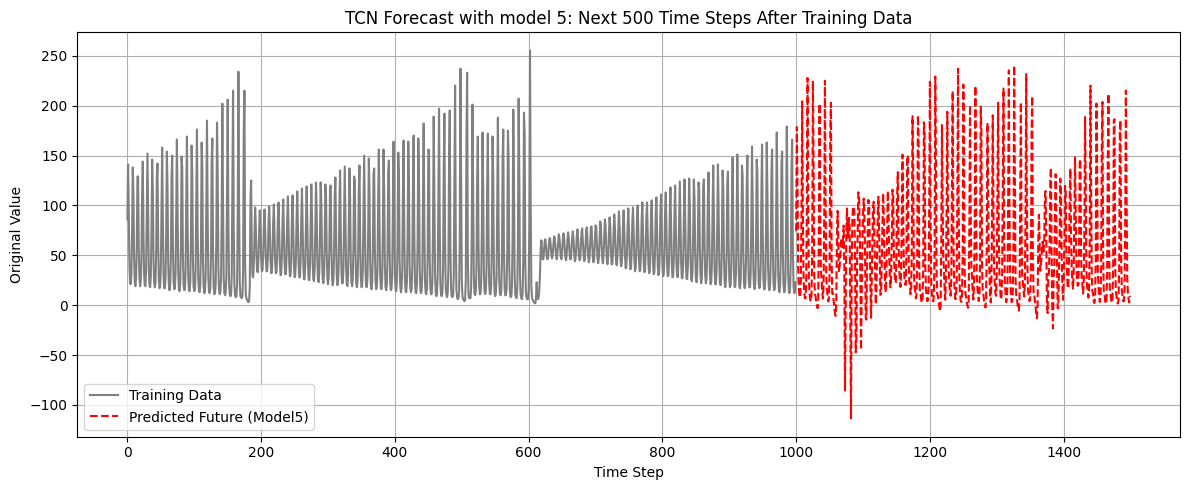

In [16]:
#Forcasting 500 points after training data for each model
train_set = x_scaled
test_set = x_scaled[:500]

X_train, y_train = create_sequences(train_set, best_k)
X_train = X_train[..., np.newaxis]  # Reshape for TCN: (batch, k, 1)

train_original = scaler.inverse_transform(train_set.reshape(-1, 1)).flatten()
train_len = len(train_set)

for i, model in enumerate(models):
    print(f"\n Predicting next 500 steps with model {i+1}")
    tcn_preds = iterative_tcn_forecast(model, train_set, scaler, best_k, n_steps=500)
    prediction_timeline = np.arange(train_len, train_len + len(tcn_preds))

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(train_original, label='Training Data', color='gray')
    plt.plot(prediction_timeline, tcn_preds, label=f'Predicted Future (Model{i+1})', color='red', linestyle='--')
    plt.title(f"TCN Forecast with model {i+1}: Next 500 Time Steps After Training Data")
    plt.xlabel("Time Step")
    plt.ylabel("Original Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
#Saving each models
import os
save_path = "/content/drive/MyDrive/tcn_models"
os.makedirs(save_path, exist_ok=True)

for i, model in enumerate(models):
  model.save(f"{save_path}/tcn_model_fold_{i+1}.h5")
  print(f"Saved model {i+1} to Google Drive at {save_path}/tcn_model_fold_{i+1}.h5")


Saved model 1 to Google Drive at /content/drive/MyDrive/tcn_models/tcn_model_fold_1.h5
Saved model 2 to Google Drive at /content/drive/MyDrive/tcn_models/tcn_model_fold_2.h5


Saved model 3 to Google Drive at /content/drive/MyDrive/tcn_models/tcn_model_fold_3.h5
Saved model 4 to Google Drive at /content/drive/MyDrive/tcn_models/tcn_model_fold_4.h5
Saved model 5 to Google Drive at /content/drive/MyDrive/tcn_models/tcn_model_fold_5.h5


In [18]:
#Test dataset
test_data_raw = scipy.io.loadmat('/content/drive/MyDrive/Xtest.mat')['Xtest'].flatten()
test_data_scaled = scaler.transform(test_data_raw.reshape(-1, 1)).flatten()


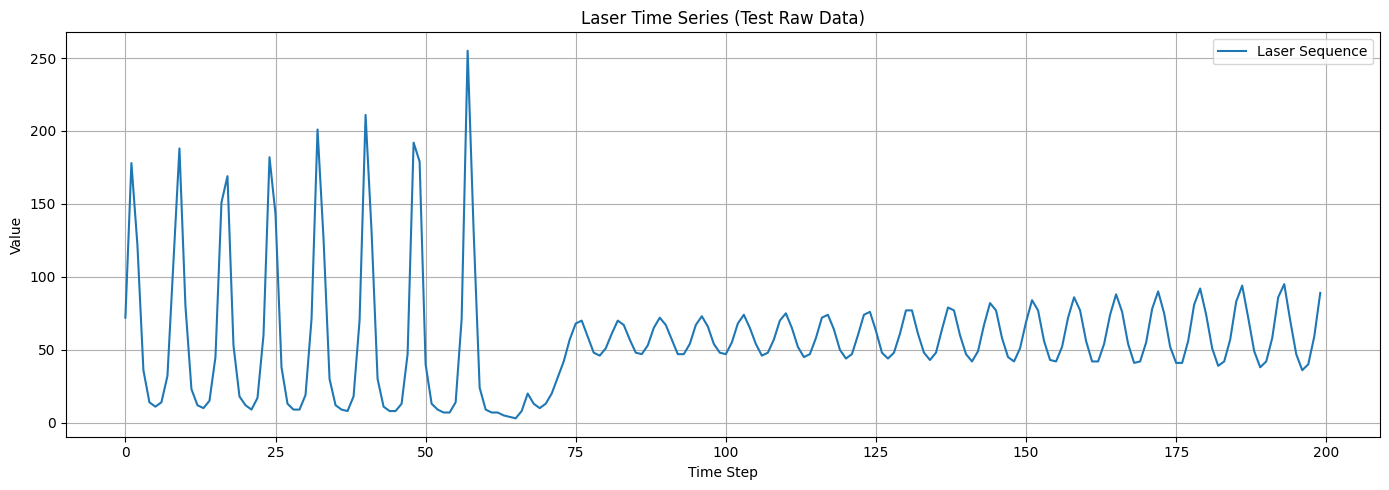

In [19]:
#Visualizing test dataset
plt.figure(figsize=(14, 5))
plt.plot(test_data_raw, label='Laser Sequence')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Laser Time Series (Test Raw Data)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Predicting with model 1


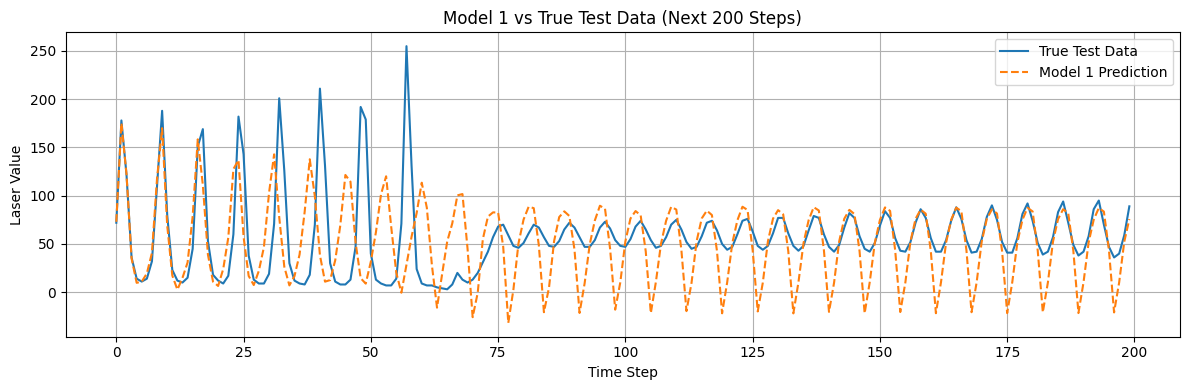


Predicting with model 2


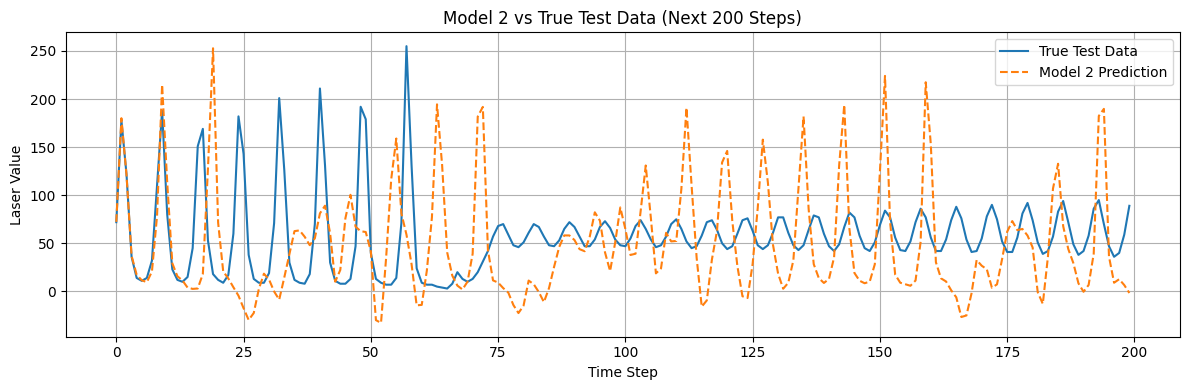


Predicting with model 3


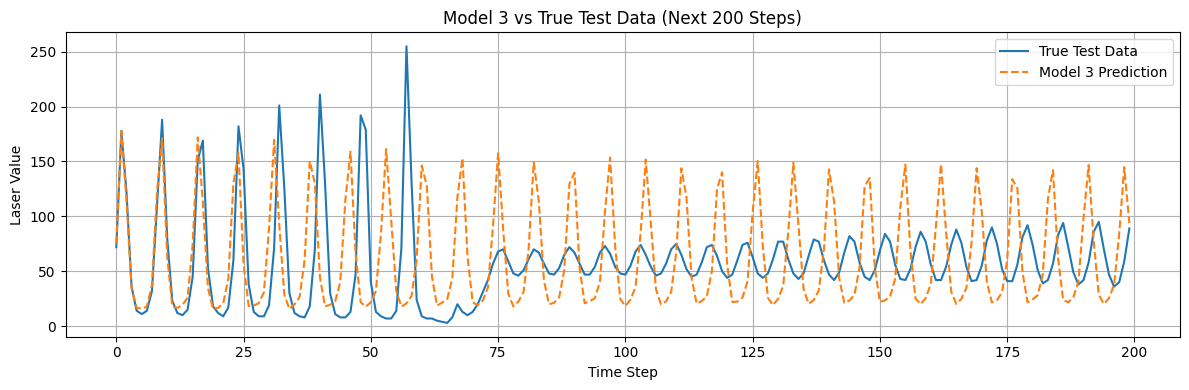


Predicting with model 4


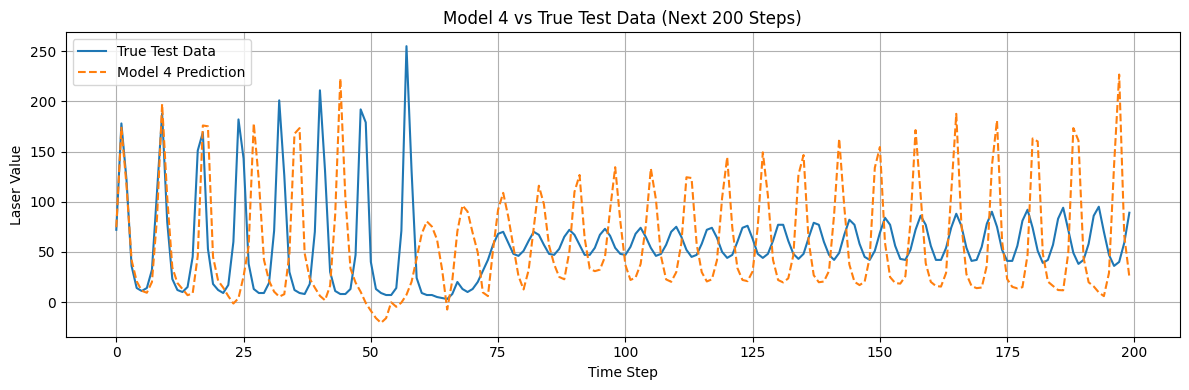


Predicting with model 5


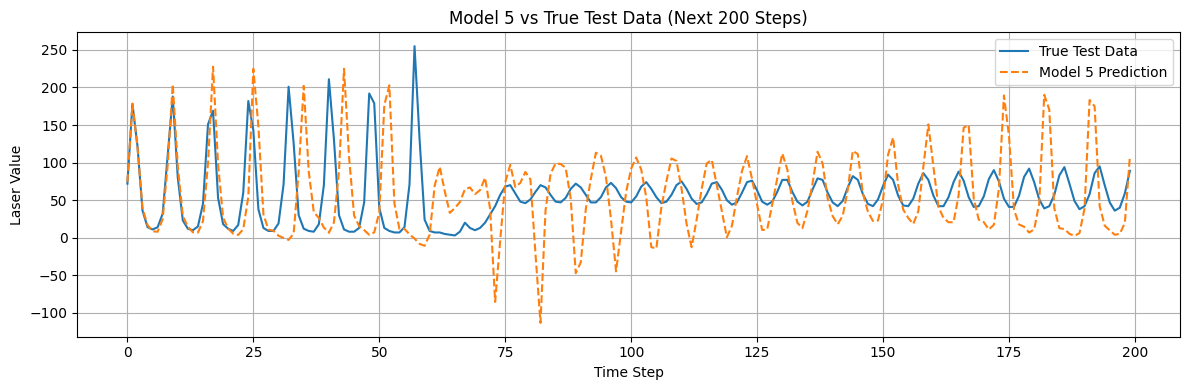

In [20]:
#Prediction of next 200 steps using all models
all_predictions = []
all_mae = []
all_mse = []

for i, model in enumerate(models):
    print(f"\nPredicting with model {i+1}")
    preds = iterative_tcn_forecast(model, x_scaled, scaler, best_k, n_steps=200)
    all_predictions.append(preds)

    # Evaluate
    mae = mean_absolute_error(test_data_raw, preds)
    mse = mean_squared_error(test_data_raw, preds)
    all_mae.append(mae)
    all_mse.append(mse)

    # Plot individual model prediction
    plt.figure(figsize=(12, 4))
    plt.plot(test_data_raw, label='True Test Data')
    plt.plot(preds, label=f'Model {i+1} Prediction', linestyle='--')
    plt.title(f'Model {i+1} vs True Test Data (Next 200 Steps)')
    plt.xlabel('Time Step')
    plt.ylabel('Laser Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
# Print summary of losses
for i in range(len(models)):
    print(f"Model {i+1} - MAE: {all_mae[i]:.4f}, MSE: {all_mse[i]:.4f}")

Model 1 - MAE: 32.0592, MSE: 2376.7502
Model 2 - MAE: 50.1194, MSE: 4585.9390
Model 3 - MAE: 45.0140, MSE: 3554.2351
Model 4 - MAE: 49.3900, MSE: 4555.1885
Model 5 - MAE: 46.3586, MSE: 4420.1240


In [22]:
# Compute ensemble average prediction
ensemble_preds = np.mean(np.array(all_predictions), axis=0)
ensemble_mae = mean_absolute_error(test_data_raw, ensemble_preds)
ensemble_mse = mean_squared_error(test_data_raw, ensemble_preds)

print(f"\nEnsemble - MAE: {ensemble_mae:.4f}, RMSE: {ensemble_mse:.4f}")


Ensemble - MAE: 26.1785, RMSE: 1816.8315


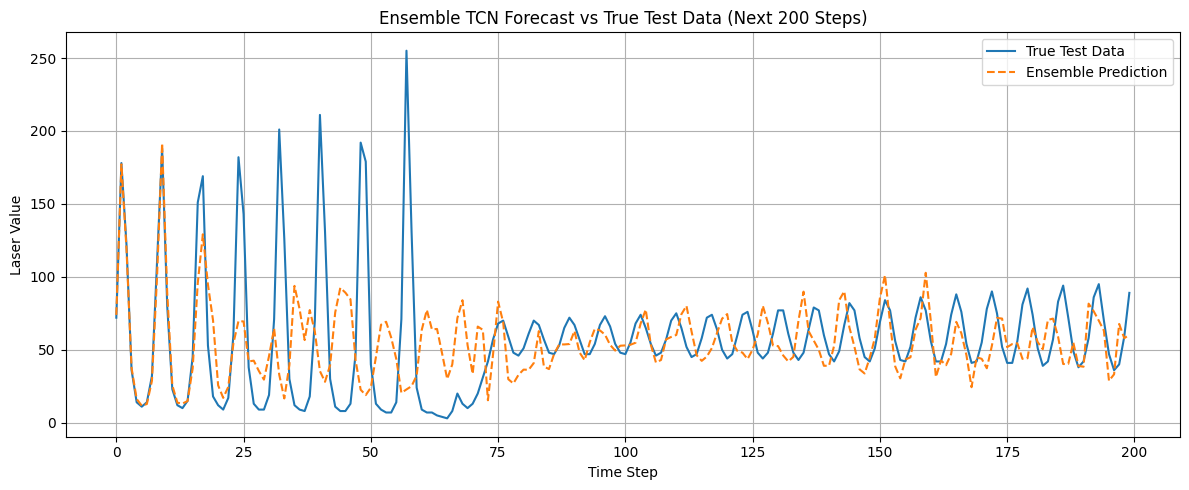

In [23]:
# Plot ensemble result
plt.figure(figsize=(12, 5))
plt.plot(test_data_raw, label='True Test Data')
plt.plot(ensemble_preds, label='Ensemble Prediction', linestyle='--')
plt.title('Ensemble TCN Forecast vs True Test Data (Next 200 Steps)')
plt.xlabel('Time Step')
plt.ylabel('Laser Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()